In [7]:
import os
import json
import torch
import functions_video_model as functions
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
import cv2
import numpy as np

First we have to load the video files and select the ones we are interested in. We create different sets of videos:
- cleaned_videos: all videos for which the speaker gender has been identified
- F_videos: all videos in which the speaker is a woman
- M_videos: all videos in which the speaker is a man

In [3]:
# Directory containing the videos
video_dir = 'data/mmsd_raw_data/utterances_final/'

# Get a list of all video files in the directory
video_files = [os.path.join(video_dir, f) for f in os.listdir(video_dir) if f.endswith('.mp4')]

In [4]:
# Read the JSON files from data labeling
with open('data/mixed_train_set.json') as file:
    mixed_train = json.load(file)

with open('data/mixed_val_set.json') as file:
    mixed_val = json.load(file)

with open('data/F_train_set.json') as file:
    F_train = json.load(file)

with open('data/F_val_set.json') as file:
    F_val = json.load(file)

with open('data/M_train_set.json') as file:
    M_train = json.load(file)

with open('data/M_val_set.json') as file:
    M_val = json.load(file)

# Extract the keys from the JSON data
mixed_train_keys = list(mixed_train.keys())
mixed_val_keys = list(mixed_val.keys())
F_train_keys = list(F_train.keys())
F_val_keys = list(F_val.keys())
M_train_keys = list(M_train.keys())
M_val_keys = list(M_val.keys())

# Get a list of video files
mixed_train_videos = [video for video in video_files if os.path.splitext(os.path.basename(video))[0] in mixed_train_keys]
mixed_val_videos = [video for video in video_files if os.path.splitext(os.path.basename(video))[0] in mixed_val_keys]
F_train_videos = [video for video in video_files if os.path.splitext(os.path.basename(video))[0] in F_train_keys]
F_val_videos = [video for video in video_files if os.path.splitext(os.path.basename(video))[0] in F_val_keys]
M_train_videos = [video for video in video_files if os.path.splitext(os.path.basename(video))[0] in M_train_keys]
M_val_videos = [video for video in video_files if os.path.splitext(os.path.basename(video))[0] in M_val_keys]

# Extract sarcasm labels
mixed_train_sarcasm_labels = {os.path.splitext(os.path.basename(key))[0]: int(value['sarcasm']) for key, value in mixed_train.items()}
mixed_val_sarcasm_labels = {os.path.splitext(os.path.basename(key))[0]: int(value['sarcasm']) for key, value in mixed_val.items()}
F_train_sarcasm_labels = {os.path.splitext(os.path.basename(key))[0]: int(value['sarcasm']) for key, value in F_train.items()}
F_val_sarcasm_labels = {os.path.splitext(os.path.basename(key))[0]: int(value['sarcasm']) for key, value in F_val.items()}
M_train_sarcasm_labels = {os.path.splitext(os.path.basename(key))[0]: int(value['sarcasm']) for key, value in M_train.items()}
M_val_sarcasm_labels = {os.path.splitext(os.path.basename(key))[0]: int(value['sarcasm']) for key, value in M_val.items()}

# Prepare datasets for training
mixed_train_data = [{'video_path': path, 'sarcasm': mixed_train_sarcasm_labels[os.path.splitext(os.path.basename(path))[0]]} for path in mixed_train_videos]
mixed_val_data = [{'video_path': path, 'sarcasm': mixed_val_sarcasm_labels[os.path.splitext(os.path.basename(path))[0]]} for path in mixed_val_videos]
female_train_data = [{'video_path': path, 'sarcasm': F_train_sarcasm_labels[os.path.splitext(os.path.basename(path))[0]]} for path in F_train_videos]
female_val_data = [{'video_path': path, 'sarcasm': F_val_sarcasm_labels[os.path.splitext(os.path.basename(path))[0]]} for path in F_val_videos]
male_train_data = [{'video_path': path, 'sarcasm': M_train_sarcasm_labels[os.path.splitext(os.path.basename(path))[0]]} for path in M_train_videos]
male_val_data = [{'video_path': path, 'sarcasm': M_val_sarcasm_labels[os.path.splitext(os.path.basename(path))[0]]} for path in M_val_videos]

Let's define some classes and functions needed in the training pipeline.

In [8]:
# Class for the PyTorch sarcasm detection Dataset
class VideoDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        video_path = item['video_path']
        sarcasm = int(item['sarcasm'])
        video_features = extract_video_features(video_path)
        return video_features, sarcasm
    

# Class for the model
class SarcasmDetectionModel(nn.Module):
    def __init__(self, num_classes):
        super(SarcasmDetectionModel, self).__init__()
        self.i3d = models.video.r3d_18(pretrained=True)
        self.i3d.fc = nn.Identity()  # Remove final fully connected layer
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        features = self.i3d(x)
        logits = self.classifier(features)
        return logits
    


def extract_video_features(video_path, sample_rate=5):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Only add frame to list every 'sample_rate' frames
        if frame_count % sample_rate == 0:
            frame = cv2.resize(frame, (128, 128))  # Resize frame
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            frames.append(frame)
        frame_count += 1
    
    cap.release()
    
    # Convert list of numpy arrays to a single numpy array
    frames_array = np.array(frames)
    # Convert numpy array to torch tensor
    video_tensor = torch.tensor(frames_array, dtype=torch.float32)

    #video_tensor = torch.tensor(frames, dtype=torch.float32)  # Convert frames to tensor
    video_tensor = video_tensor.permute(3, 0, 1, 2)  # Should be [C, T, H, W]
    
    return video_tensor

We will now train 3 different models: 
- one model will be trained on all of the videos (video_files)
- one model will be trained on videos from female speakers only (F_videos)
- one model will be trained on videos from male speakers only (M_videos)

c:\Users\celin\anaconda3\envs\DLproj\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\celin\anaconda3\envs\DLproj\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/8


C:\Users\celin\AppData\Local\Temp\ipykernel_2828\3053690969.py:54: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  video_tensor = torch.tensor(frames, dtype=torch.float32)  # Convert frames to tensor


train Loss: 0.6990 , train Acc: 0.5614
test Loss: 1.1691 , test Acc: 0.6421


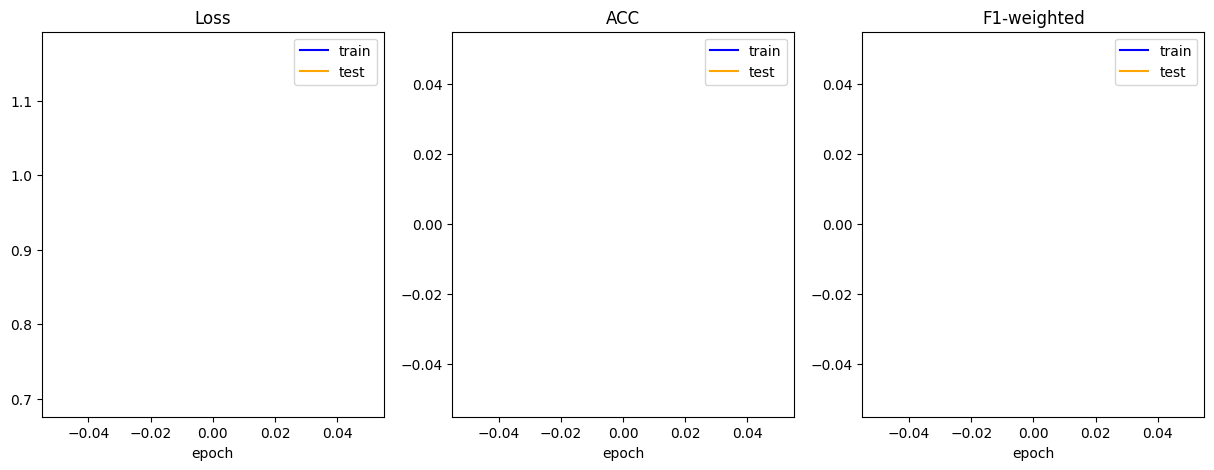

Epoch 2/8
train Loss: 0.6767 , train Acc: 0.5682
test Loss: 3.2056 , test Acc: 0.6000


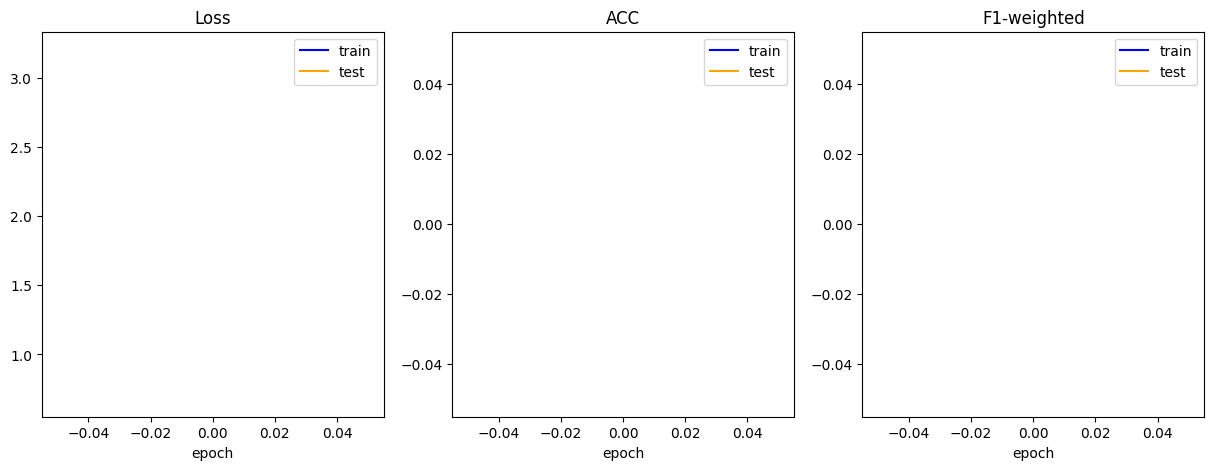

Epoch 3/8
train Loss: 0.6706 , train Acc: 0.6045
test Loss: 0.6972 , test Acc: 0.5474


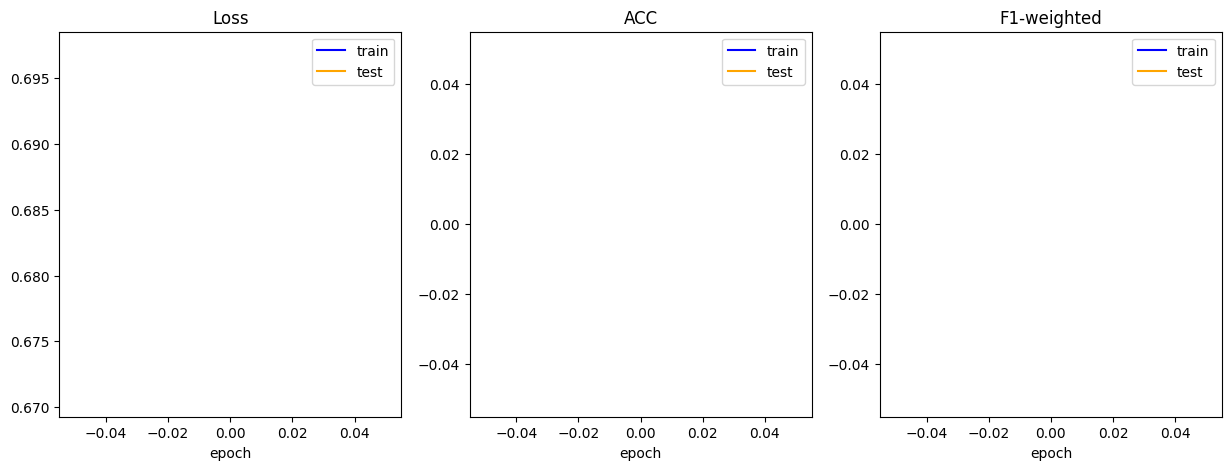

Epoch 4/8
train Loss: 0.6571 , train Acc: 0.6318
test Loss: 0.8082 , test Acc: 0.6316


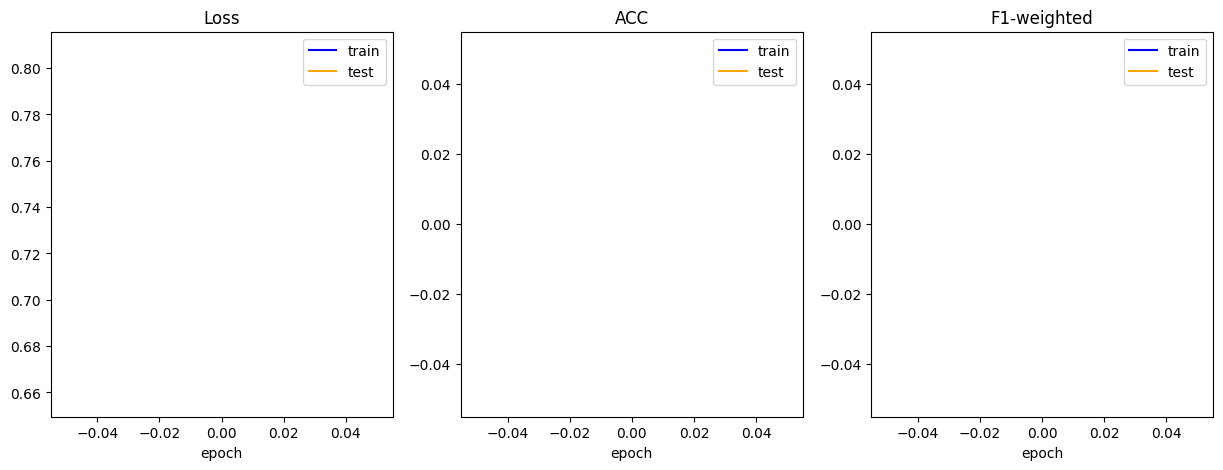

Epoch 5/8
train Loss: 0.6411 , train Acc: 0.6341
test Loss: 0.7255 , test Acc: 0.5789


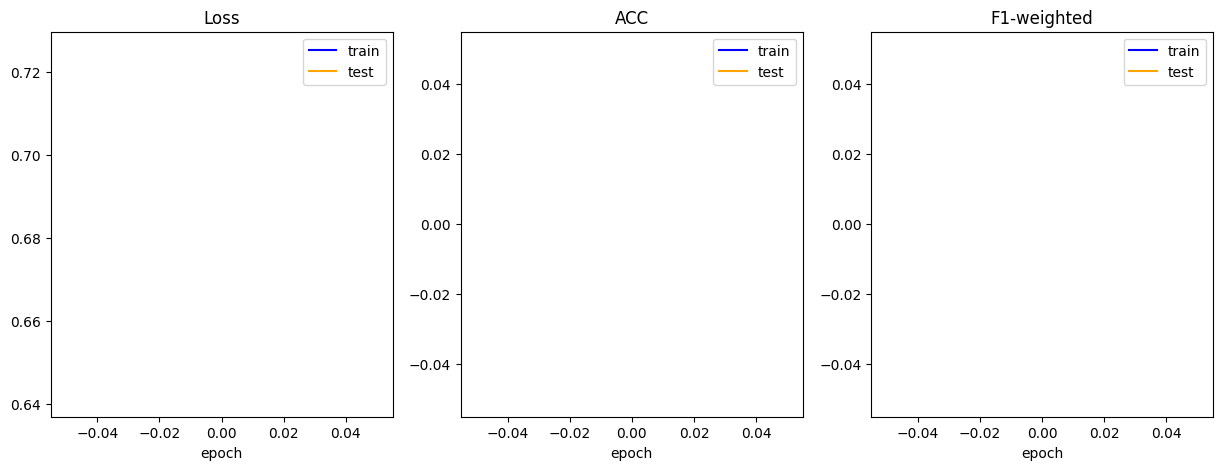

Epoch 6/8
train Loss: 0.6426 , train Acc: 0.6341
test Loss: 1.0545 , test Acc: 0.6105


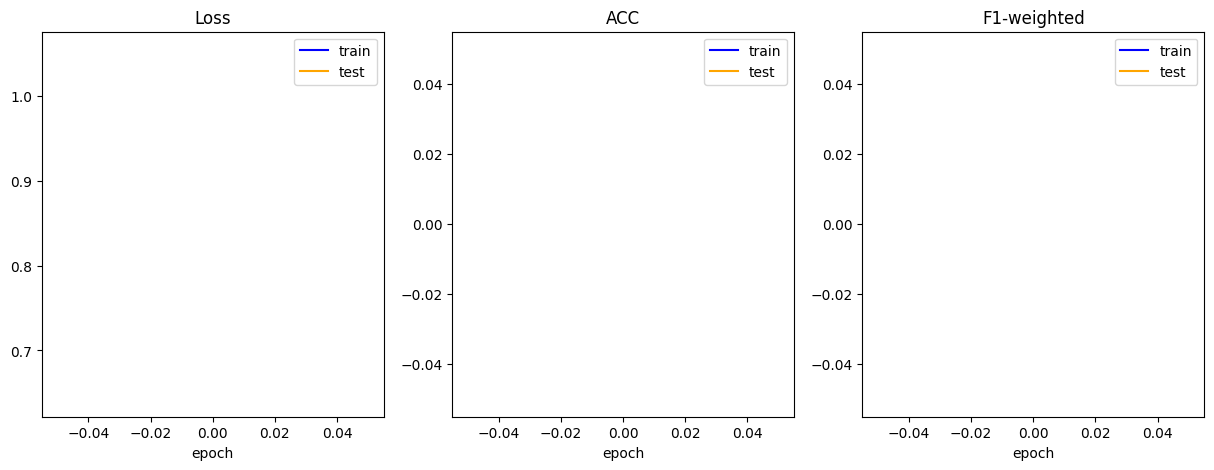

Epoch 7/8
train Loss: 0.6249 , train Acc: 0.6523
test Loss: 0.7569 , test Acc: 0.6211


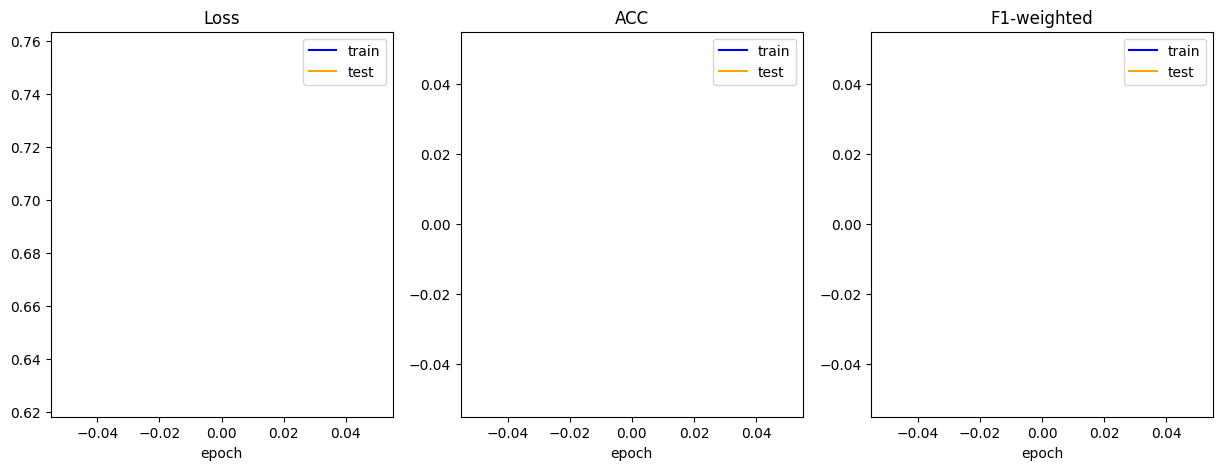

Epoch 8/8
train Loss: 0.6347 , train Acc: 0.6432
test Loss: 0.6800 , test Acc: 0.6316


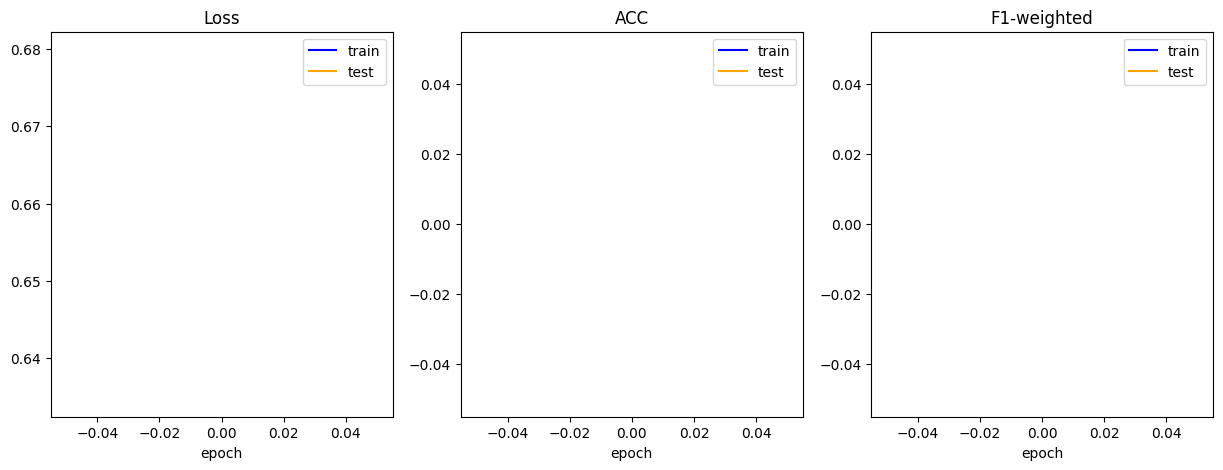

In [5]:
# MIXED MODEL 1

# Set seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cpu")

# Set hyperparameters
learning_rate = 0.001
num_epochs = 8
batch_size = 8
weight_decay = 0.05
dropout_prob = 0

# Split dataset into training and testing
train_dataset = VideoDataset(mixed_train_data)
val_dataset = VideoDataset(mixed_val_data)

# Initialize dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=functions.custom_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=functions.custom_collate_fn)

# Initialize the model
mixed_model = SarcasmDetectionModel(num_classes=2).to(device)

# Define optimizer and criterion
optimizer = optim.AdamW(mixed_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# Define metrics
metrics = {'ACC': functions.acc, 'F1-weighted': functions.f1}
metrics_names = list(metrics.keys())
train_metrics_log = [[] for i in range(len(metrics))]
val_metrics_log = [[] for i in range(len(metrics))]

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = functions.train_epoch(mixed_model, train_dataloader, criterion, optimizer, device)
    test_loss, test_acc = functions.evaluate_model(mixed_model, val_dataloader, criterion, device)
    functions.plot_training(train_loss, test_loss, metrics_names, train_metrics_log, val_metrics_log)

# Save model
torch.save(mixed_model.state_dict(), 'models/mixed_model_1_video.pth')


In [5]:
# MIXED MODEL 2

# Set seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cpu")

# Set hyperparameters
learning_rate = 0.001
num_epochs = 8 
batch_size = 32
weight_decay = 0.05
dropout_prob = 0

# Split dataset into training and testing
train_dataset = VideoDataset(mixed_train_data)
val_dataset = VideoDataset(mixed_val_data)

# Initialize dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=functions.custom_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=functions.custom_collate_fn)

# Initialize the model
mixed_model = SarcasmDetectionModel(num_classes=2).to(device)

# Define optimizer and criterion
optimizer = optim.AdamW(mixed_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = functions.train_epoch(mixed_model, train_dataloader, criterion, optimizer, device)
    test_loss, test_acc = functions.evaluate_model(mixed_model, val_dataloader, criterion, device)

# Save model
torch.save(mixed_model.state_dict(), 'models/mixed_model_2_video.pth')

c:\Users\celin\anaconda3\envs\DLproj\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\celin\anaconda3\envs\DLproj\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/8


C:\Users\celin\AppData\Local\Temp\ipykernel_10100\3053690969.py:54: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  video_tensor = torch.tensor(frames, dtype=torch.float32)  # Convert frames to tensor


train Loss: 0.6795 , train Acc: 0.6000
test Loss: 0.9890 , test Acc: 0.6105
Epoch 2/8
train Loss: 0.6488 , train Acc: 0.6386
test Loss: 2.1481 , test Acc: 0.4842
Epoch 3/8
train Loss: 0.5676 , train Acc: 0.7091
test Loss: 0.7097 , test Acc: 0.6105
Epoch 4/8
train Loss: 0.5633 , train Acc: 0.7068
test Loss: 0.6884 , test Acc: 0.6000
Epoch 5/8
train Loss: 0.5072 , train Acc: 0.7500
test Loss: 0.8906 , test Acc: 0.5579
Epoch 6/8
train Loss: 0.4941 , train Acc: 0.7614
test Loss: 0.8332 , test Acc: 0.6316
Epoch 7/8


In [9]:
# MIXED MODEL 3

# Set seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cpu")

# Set hyperparameters
learning_rate = 0.0001
num_epochs = 8 
batch_size = 8 # or 8?
weight_decay = 0.05
dropout_prob = 0

# Split dataset into training and testing
train_dataset = VideoDataset(mixed_train_data)
val_dataset = VideoDataset(mixed_val_data)

# Initialize dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=functions.custom_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=functions.custom_collate_fn)

# Initialize the model
mixed_model = SarcasmDetectionModel(num_classes=2).to(device)

# Define optimizer and criterion
optimizer = optim.AdamW(mixed_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = functions.train_epoch(mixed_model, train_dataloader, criterion, optimizer, device)
    test_loss, test_acc = functions.evaluate_model(mixed_model, val_dataloader, criterion, device)

# Save model
torch.save(mixed_model.state_dict(), 'models/mixed_model_3_video.pth')

c:\Users\celin\anaconda3\envs\DLproj\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\celin\anaconda3\envs\DLproj\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/8
train Loss: 0.6358 , train Acc: 0.6409
test Loss: 0.6201 , test Acc: 0.6947
Epoch 2/8
train Loss: 0.3938 , train Acc: 0.8227
test Loss: 1.0140 , test Acc: 0.6316
Epoch 3/8
train Loss: 0.1723 , train Acc: 0.9455
test Loss: 0.8119 , test Acc: 0.6737
Epoch 4/8
train Loss: 0.1662 , train Acc: 0.9364
test Loss: 1.0841 , test Acc: 0.6211
Epoch 5/8
train Loss: 0.1001 , train Acc: 0.9659
test Loss: 0.9726 , test Acc: 0.6316
Epoch 6/8
train Loss: 0.0754 , train Acc: 0.9773
test Loss: 0.9560 , test Acc: 0.6632
Epoch 7/8
train Loss: 0.0506 , train Acc: 0.9864
test Loss: 1.3993 , test Acc: 0.6632
Epoch 8/8
train Loss: 0.0197 , train Acc: 1.0000
test Loss: 1.2814 , test Acc: 0.6000


In [6]:
# FEMALE MODEL 1

# Set seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cpu")

# Set hyperparameters
learning_rate = 0.001
num_epochs = 8
batch_size = 8
weight_decay = 0.05
dropout_prob = 0

# Split dataset into training and testing
train_dataset = VideoDataset(female_train_data)
val_dataset = VideoDataset(female_val_data)

# Initialize dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=functions.custom_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=functions.custom_collate_fn)

# Initialize the model
F_model = SarcasmDetectionModel(num_classes=2).to(device)

# Define optimizer and criterion
optimizer = optim.AdamW(F_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = functions.train_epoch(F_model, train_dataloader, criterion, optimizer, device)
    test_loss, test_acc = functions.evaluate_model(F_model, val_dataloader, criterion, device)

    
# Save model
torch.save(F_model.state_dict(), 'models/F_model_1_video.pth')

c:\Users\celin\anaconda3\envs\DLproj\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\celin\anaconda3\envs\DLproj\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/8


C:\Users\celin\AppData\Local\Temp\ipykernel_16984\3053690969.py:54: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  video_tensor = torch.tensor(frames, dtype=torch.float32)  # Convert frames to tensor


train Loss: 0.6722 , train Acc: 0.5816
test Loss: 121.6536 , test Acc: 0.5000
Epoch 2/8
train Loss: 0.6472 , train Acc: 0.6454
test Loss: 1.9802 , test Acc: 0.7812
Epoch 3/8
train Loss: 0.5906 , train Acc: 0.6738
test Loss: 0.8368 , test Acc: 0.7188
Epoch 4/8
train Loss: 0.5567 , train Acc: 0.7447
test Loss: 1.2992 , test Acc: 0.6875
Epoch 5/8
train Loss: 0.4879 , train Acc: 0.7660
test Loss: 3.2674 , test Acc: 0.6562
Epoch 6/8
train Loss: 0.5419 , train Acc: 0.7589
test Loss: 2.2192 , test Acc: 0.6562
Epoch 7/8
train Loss: 0.5248 , train Acc: 0.7234
test Loss: 1.4121 , test Acc: 0.6562
Epoch 8/8
train Loss: 0.4136 , train Acc: 0.7943
test Loss: 1.5208 , test Acc: 0.6562


In [ ]:
# MALE MODEL

# Set seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cpu")

# Set hyperparameters
learning_rate = 0.001
num_epochs = 5
batch_size = 32
weight_decay = 0.05
dropout_prob = 0

# Split dataset into training and testing
train_dataset = VideoDataset(male_train_data)
val_dataset = VideoDataset(male_val_data)

# Initialize dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=functions.custom_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=functions.custom_collate_fn)

# Initialize the model
M_model = SarcasmDetectionModel(num_classes=2).to(device)

# Define optimizer and criterion
optimizer = optim.AdamW(M_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# Define metrics
metrics = {'ACC': functions.acc, 'F1-weighted': functions.f1}
metrics_names = list(metrics.keys())
train_metrics_log = [[] for i in range(len(metrics))]
val_metrics_log = [[] for i in range(len(metrics))]

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = functions.train_epoch(M_model, train_dataloader, criterion, optimizer, device)
    test_loss, test_acc = functions.evaluate_model(M_model, val_dataloader, criterion, device)
    functions.plot_training(train_loss, test_loss, metrics_names, train_metrics_log, val_metrics_log)

# Save model
torch.save(M_model.state_dict(), 'models/M_model_1_video.pth')

train Loss: 0.6415 , train Acc: 0.6395
Epoch 1/5, Train Loss: 0.6415, Train Acc: 0.6395
test Loss: 0.6296 , test Acc: 0.6977
Epoch 1/5, Test Loss: 0.6296, Test Acc: 0.6977
train Loss: 0.4621 , train Acc: 0.7965
Epoch 2/5, Train Loss: 0.4621, Train Acc: 0.7965
test Loss: 1.0514 , test Acc: 0.6163
Epoch 2/5, Test Loss: 1.0514, Test Acc: 0.6163
train Loss: 0.3692 , train Acc: 0.8430
Epoch 3/5, Train Loss: 0.3692, Train Acc: 0.8430
test Loss: 0.6644 , test Acc: 0.6977
Epoch 3/5, Test Loss: 0.6644, Test Acc: 0.6977
train Loss: 0.3037 , train Acc: 0.8547
Epoch 4/5, Train Loss: 0.3037, Train Acc: 0.8547
test Loss: 1.2365 , test Acc: 0.6279
Epoch 4/5, Test Loss: 1.2365, Test Acc: 0.6279
train Loss: 0.2234 , train Acc: 0.9273
Epoch 5/5, Train Loss: 0.2234, Train Acc: 0.9273
test Loss: 0.8160 , test Acc: 0.6512
Epoch 5/5, Test Loss: 0.8160, Test Acc: 0.6512


Now that we have created, trained and saved the different models, we will evaluate their performance on the other datasets. Here are the different evaluations we will perform:
- performance of mixed_model on the female dataset
- performance of mixed_model on the male dataset
- performance of F_model on the male dataset
- performance of F_model on the mixed dataset
- performance of M_model on the female dataset
- performance of M_model on the mixed dataset